Loading the training data might take some time. (We can load a select number of rows for quick analysis)

In [1]:
import pandas as pd
train = pd.read_csv('https://media.githubusercontent.com/media/jsakhnin/JigsawNLP_data/master/train.csv', nrows=1000 )
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


I really like the way this notebook does the data analysis and data processing
https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw.

Importing libraries we need:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## New Features

We add new features to the dataset based on existing features (e.g. length of comment, number of capital letters, number of exclamation marks, etc). Some of this data could be correlated with toxicity.

In [3]:
#Adding length of comment as a column
train['total_length'] = train['comment_text'].apply(len)
#Adding number of capital letters as a column
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
#Adding ratio of capital letters vs length of comment
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)

#Adding number of exclamation marks
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
#Adding number of question marks
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
#Number of punctuations
train['num_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
#Number of symbols (*$%&)
train['num_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))

#Number of works in each comment
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
#Number of unique words
train['num_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
#Percentage of unique words in a comment
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']

#Number of smilie faces in the comment
train['num_smilies'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

We can measure the correlation of our newly created features with some of the original columns of the data.

In [4]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks',
            'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols')

columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad',
           'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')

rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

Here's what our corrleation table looks like:

In [5]:
train_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
total_length,-0.007309,-0.002259,-0.005816,0.015722,-0.016007,0.036537,NaN,NaN,NaN,0.140546,NaN,-0.012171,0.017767,-0.067341
capitals,0.008169,-0.013878,-0.003845,-0.011248,-0.003255,-0.007762,NaN,NaN,NaN,0.049364,NaN,0.004804,0.058926,-0.051525
caps_vs_length,0.018788,0.121267,0.022677,0.135440,0.006017,-0.021520,NaN,NaN,NaN,-0.070372,NaN,0.037404,0.072688,0.050077
num_exclamation_marks,-0.014195,0.072860,0.008545,-0.016048,-0.022148,-0.043826,NaN,NaN,NaN,0.004340,NaN,0.003278,-0.000544,-0.027774
num_question_marks,-0.015200,0.022691,0.036757,0.034332,-0.036069,0.006506,NaN,NaN,NaN,-0.019112,NaN,0.032974,0.007232,-0.011516
num_punctuation,0.011155,0.041567,0.004651,0.018340,-0.004069,0.001497,NaN,NaN,NaN,0.111869,NaN,-0.007577,0.015016,-0.055406
num_words,-0.000861,-0.002015,-0.001673,0.009806,-0.010911,0.034255,NaN,NaN,NaN,0.142587,NaN,-0.011318,0.020133,-0.063323
num_unique_words,0.004107,-0.003515,0.000315,0.013635,-0.003307,0.034746,NaN,NaN,NaN,0.155997,NaN,-0.012866,0.021588,-0.060093
words_vs_unique,0.003963,-0.014998,-0.000984,0.001841,0.018265,-0.039899,NaN,NaN,NaN,-0.120671,NaN,0.036305,-0.020281,0.075896
num_smilies,0.003698,-0.018228,0.044648,-0.016384,0.000259,-0.020037,NaN,NaN,NaN,-0.051360,NaN,-0.013892,-0.026733,0.030014


## Correlation with new Features

We can plot these correlations in a heatmap: (If we're not using the entire data, the heatmap may look incomplete)

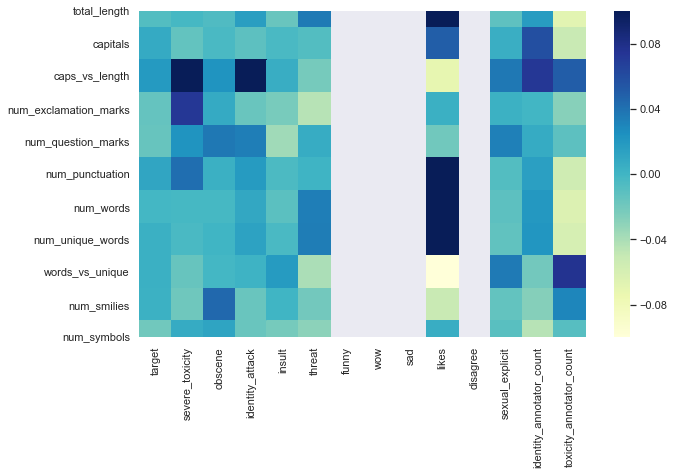

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0, cmap="YlGnBu")

## Correlation between Identities and Comment Label

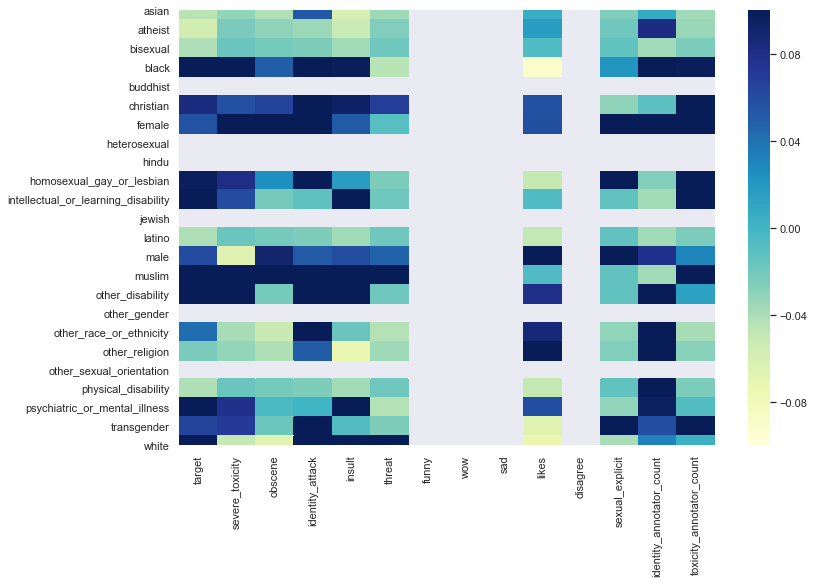

In [7]:
identities = tuple(train.iloc[:, 8:32])
rows = [{c:train[f].corr(train[c]) for c in columns} for f in identities]
poptoxicity_correlations = pd.DataFrame(rows, index=identities)

plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(poptoxicity_correlations, vmin=-0.1, vmax=0.1, center=0.0, cmap="YlGnBu")

## Demographics Analysis

We can find a rleationship between average toxicity of comments with demographic groups: (Not complete/accurate with low sample of data, we need to run this on the whole data)

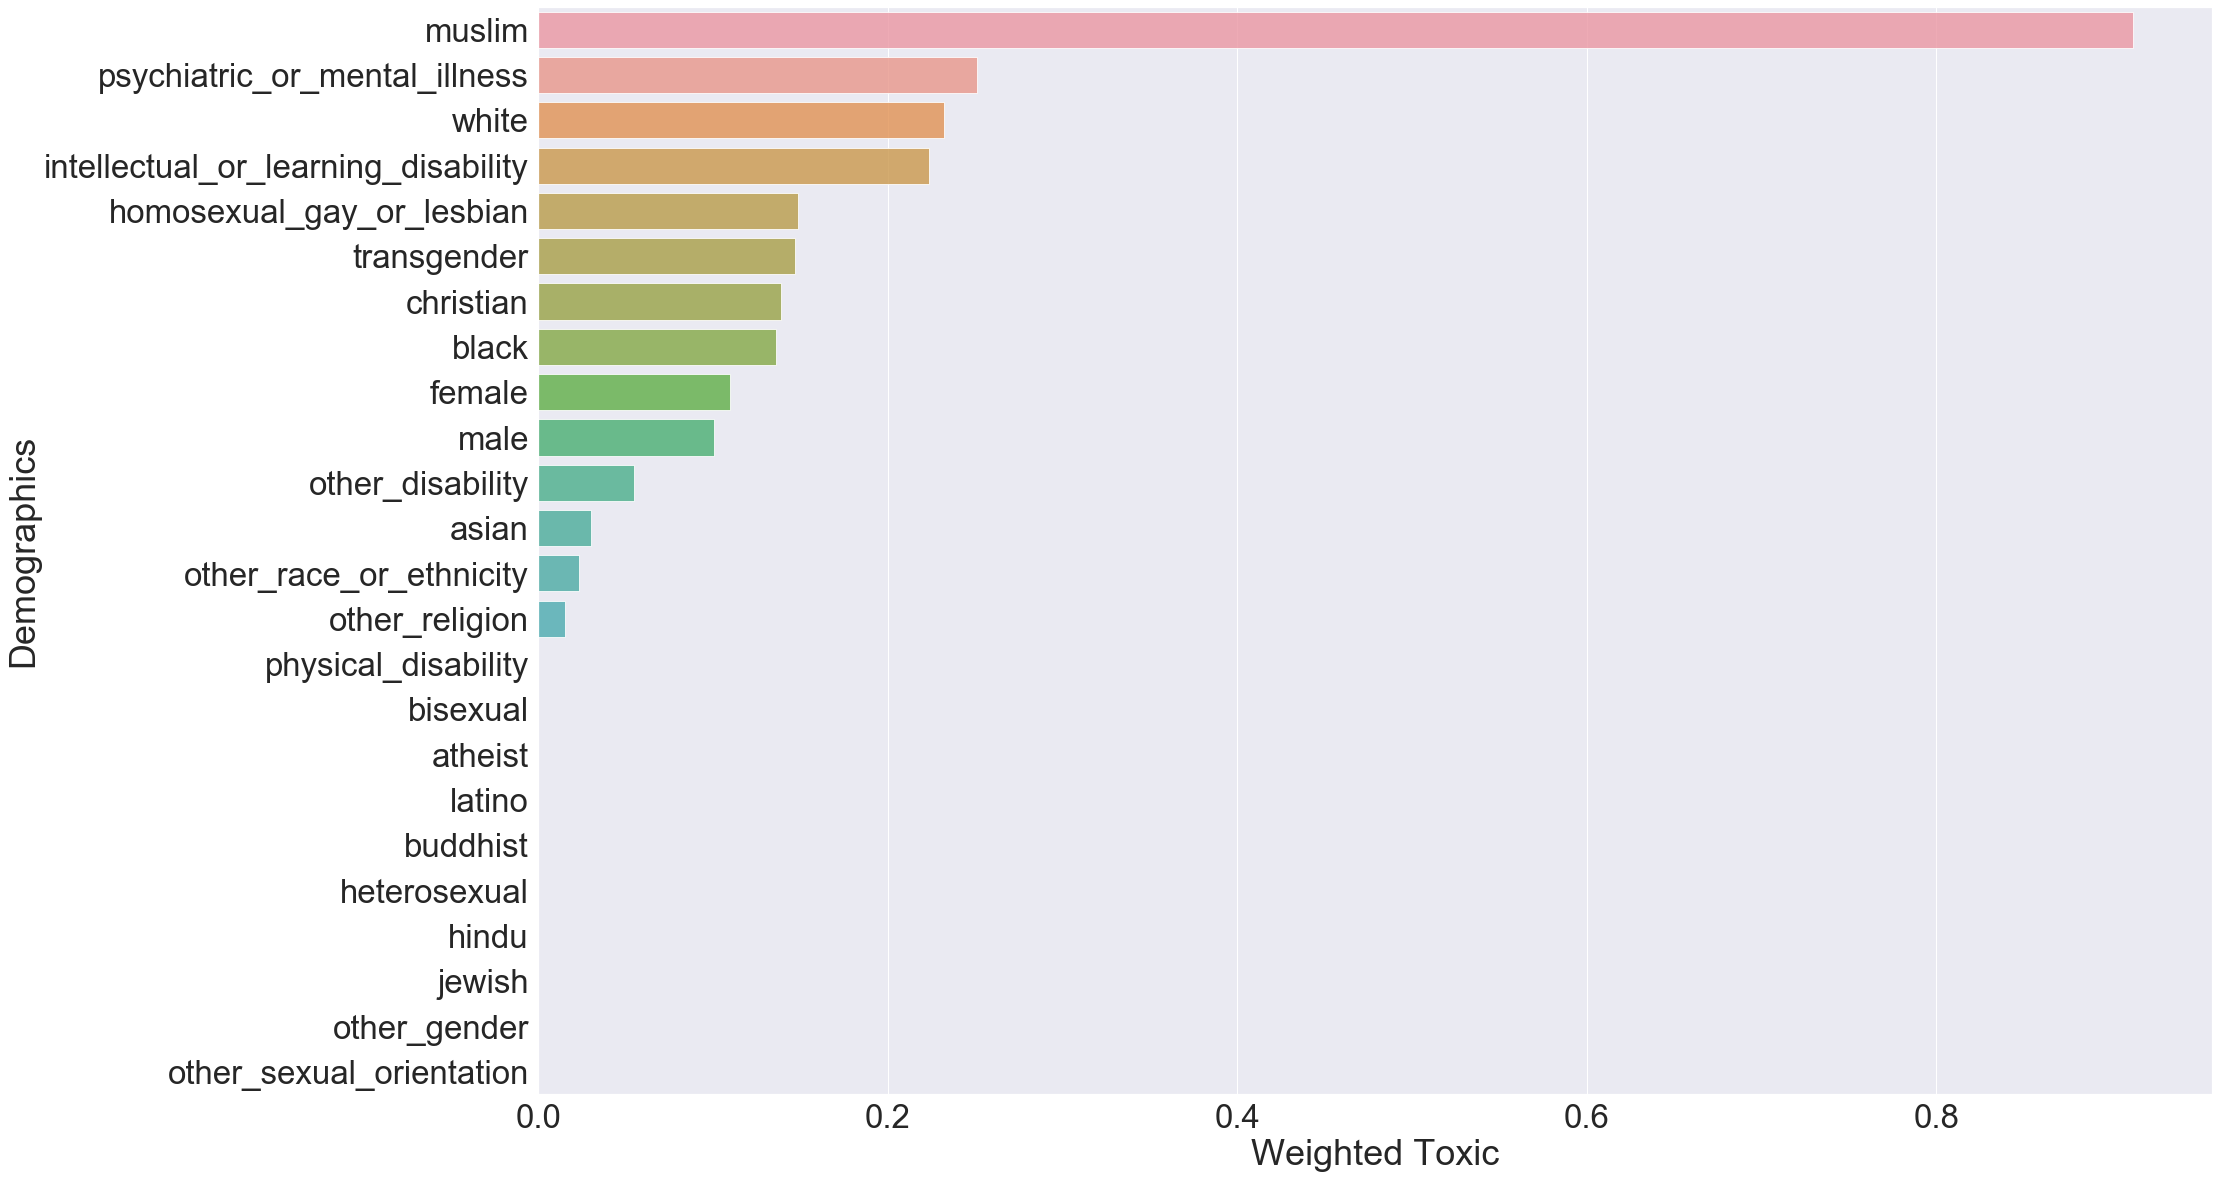

In [8]:
demographics = train.loc[:, ['target']+list(train)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)

plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.show()

In [9]:
demographics.head()

,target,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,...,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
4,0.893617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.440000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.912500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we look at samples per category:

In [10]:
cat_df = pd.DataFrame()
toxicCat = []
normalCat = []
for i in range(weighted_toxic.index.size):
#     cat_df = train.apply(lambda x: True if ( (train['target']>0.5)  & (train[weighted_toxic.index[i]] > 0)) else False, axis=1)
    cat_df_bad = train[ (train['target']>0.5) & (train[weighted_toxic.index[i]] > 0.0) ]
    cat_df_good = train[ (train['target']<0.5) & (train[weighted_toxic.index[i]] > 0.0) ]
    toxicCat.append(len(cat_df_bad))
    normalCat.append(len(cat_df_good))

Now "normalCat" and "toxicCat" contains the number of normal and toxic samples per category respectively. They are ordered the same as "weighted_toxic.index"

In [11]:
print(normalCat)
print(toxicCat)

normalCat = np.asarray(normalCat)
toxicCat = np.asarray(toxicCat)
samplesPerCategory = np.vstack((normalCat, toxicCat))

print(normalCat.shape)
print(toxicCat.shape)
print(samplesPerCategory.shape)

[0, 4, 8, 0, 2, 2, 6, 6, 15, 19, 0, 5, 5, 4, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0]
[1, 3, 0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(24,)
(24,)
(2, 24)


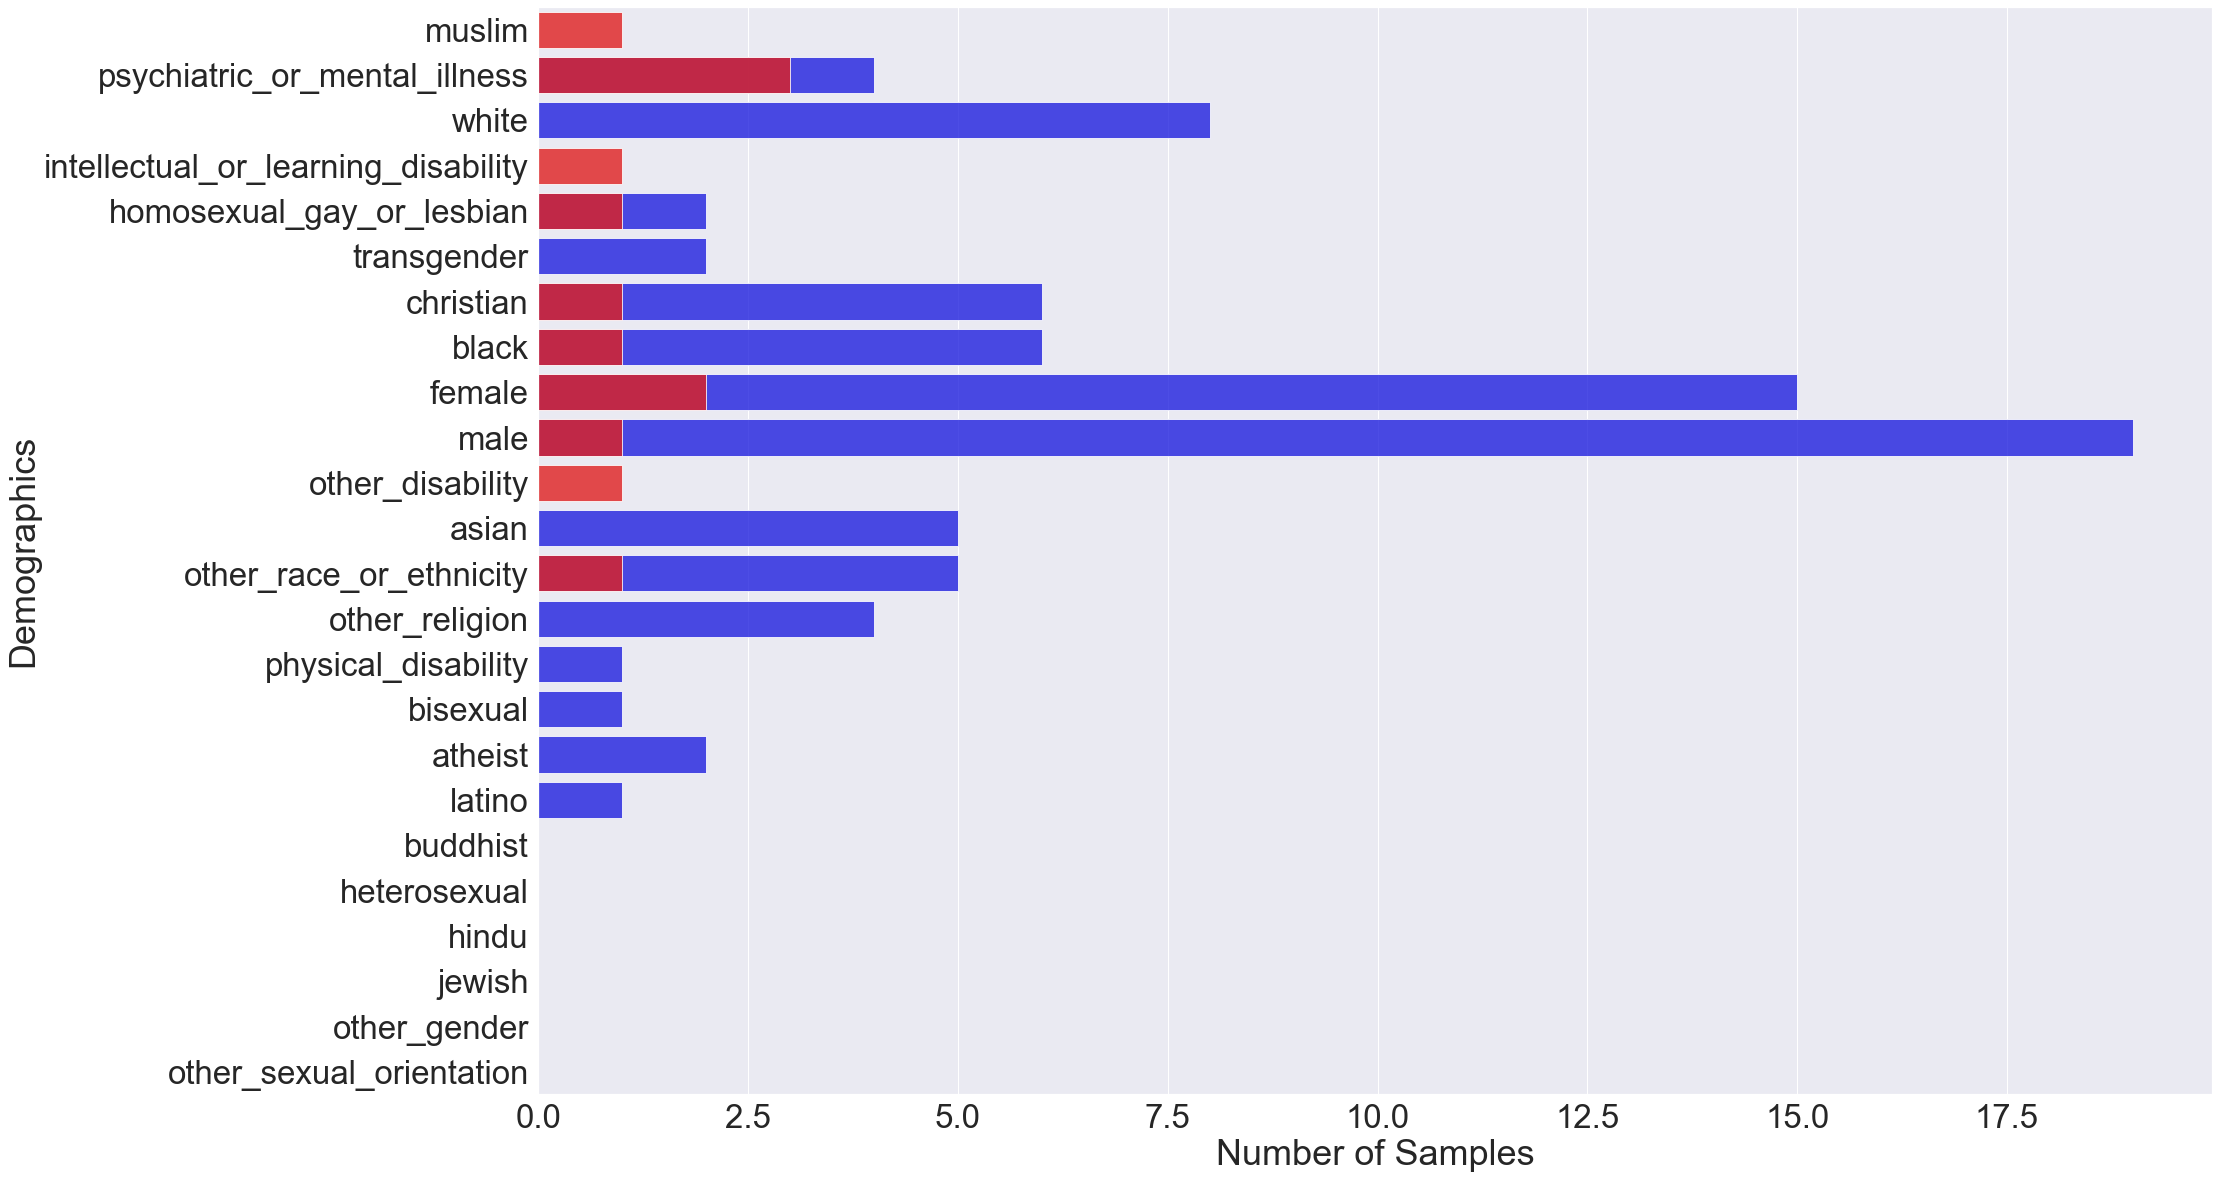

In [12]:

plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = normalCat, y = weighted_toxic.index, alpha=0.8, color="blue")
ax = sns.barplot(x = toxicCat, y = weighted_toxic.index, alpha=0.8, color="red")
plt.ylabel('Demographics')
plt.xlabel('Number of Samples')
plt.show()

## Time-Series Plots

First we weight the data based on dates and labels

In [13]:
withdate = train.loc[:, ['created_date', 'target']+list(train)[slice(8,32)]].dropna()
raceweighted = withdate.iloc[:, 2:]/withdate.iloc[:, 2:].sum()
race_target_weighted = raceweighted.multiply(withdate.iloc[:, 1], axis="index")
race_target_weighted['created_date'] = pd.to_datetime(withdate['created_date']).values.astype('datetime64[M]')
weighted_demo = race_target_weighted.groupby(['created_date']).sum().sort_index()

Editing Sizes of Plots:

In [15]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space

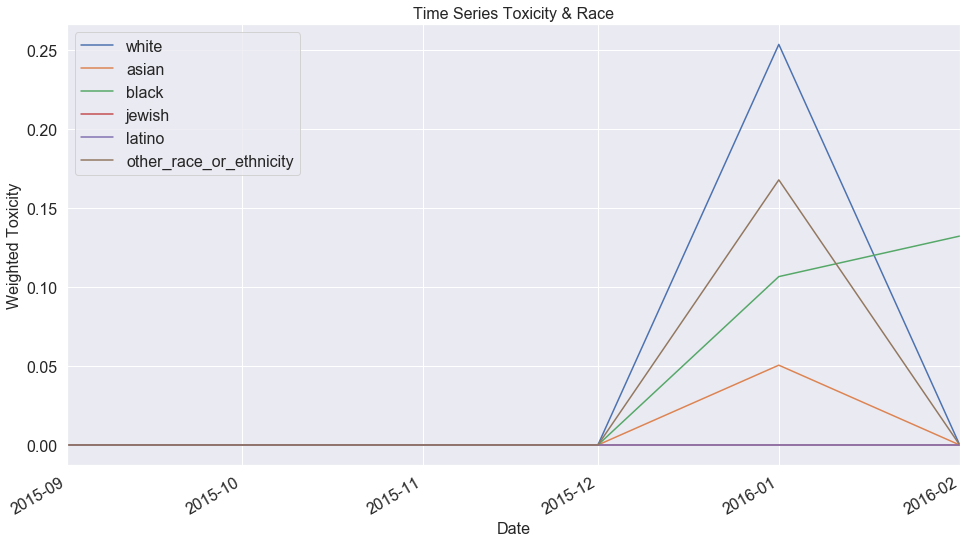

In [28]:
weighted_demo[['white', 'asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity']].plot(
    title = 'Time Series Toxicity & Race' )
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Date')
plt.ylabel('Weighted Toxicity')
plt.legend()
plt.savefig('Toxicity_vs_Race.png')

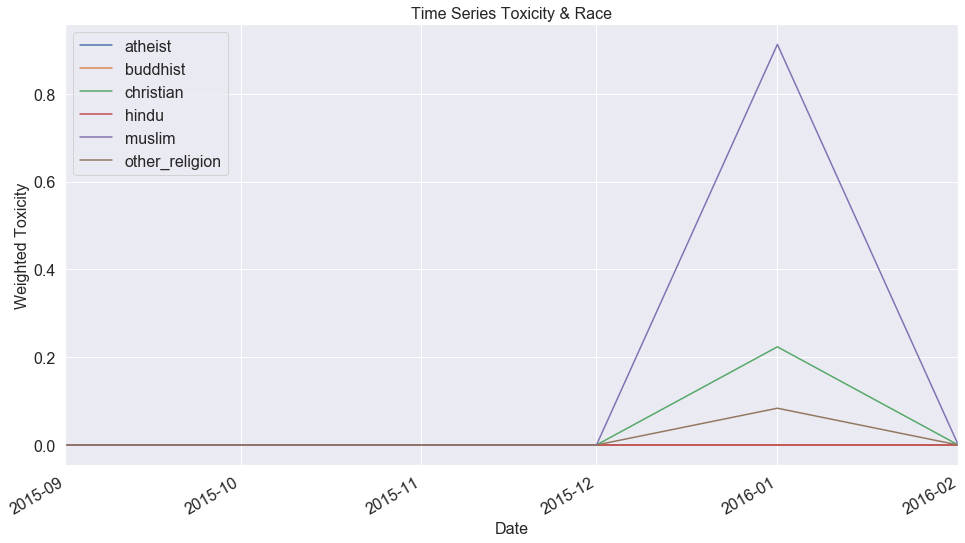

In [29]:
weighted_demo[['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion']].plot(
    title = 'Time Series Toxicity & Race' )
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Date')
plt.ylabel('Weighted Toxicity')
plt.legend()
plt.savefig('Toxicity_vs_Religion.png')

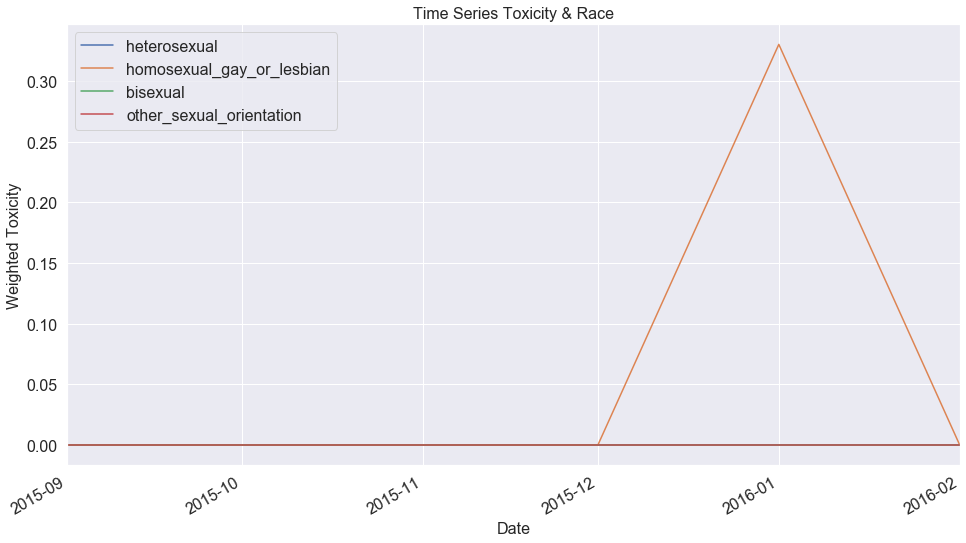

In [30]:
weighted_demo[['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']].plot(
    title = 'Time Series Toxicity & Race' )
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Date')
plt.ylabel('Weighted Toxicity')
plt.legend()
plt.savefig('Toxicity_vs_SexualOrientation.png')

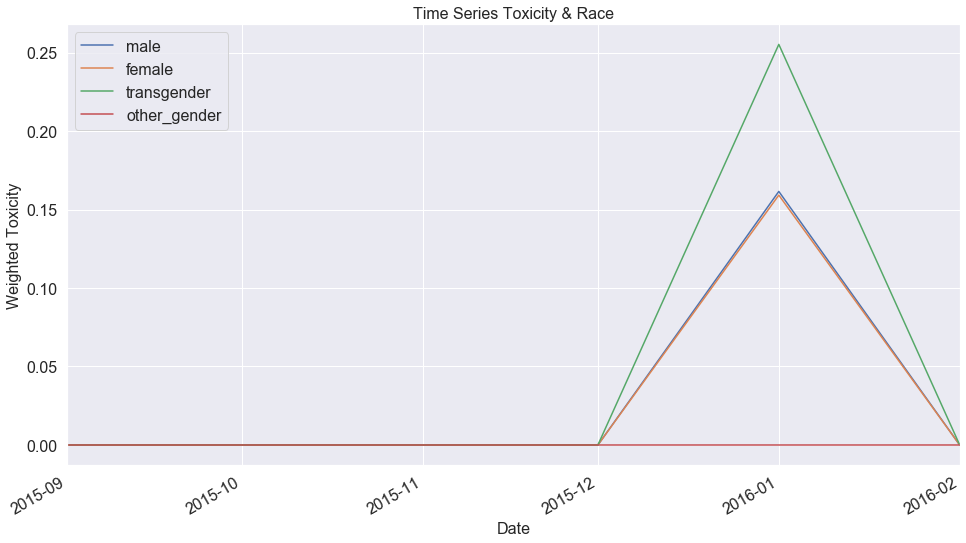

In [31]:
weighted_demo[['male', 'female', 'transgender', 'other_gender']].plot(
    title = 'Time Series Toxicity & Race' )
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Date')
plt.ylabel('Weighted Toxicity')
plt.legend()
plt.savefig('Toxicity_vs_Gender.png')

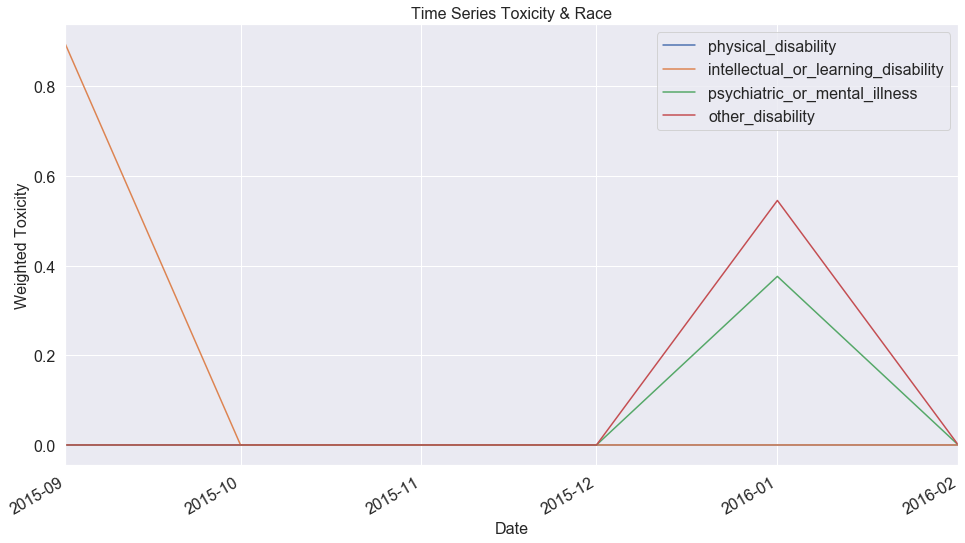

In [32]:
weighted_demo[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].plot(
    title = 'Time Series Toxicity & Race' )
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Date')
plt.ylabel('Weighted Toxicity')
plt.legend()
plt.savefig('Toxicity_vs_Disability.png')